In [1]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers, models, callbacks, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, roc_auc_score, precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA

from tqdm import tqdm
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

# Dataset preprocessing

In [2]:
#Loading first dataset
dataset1_train = 'data/train'
dataset1_test = 'data/test'

In [3]:
#Converting to dataframe
def create_df(data_dir):
    data = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                data.append({'file_path': os.path.join(class_path, filename), 'label': class_name})
    return pd.DataFrame(data)

train_df = create_df(dataset1_train)
test_df = create_df(dataset1_test)

In [4]:
print("Train set summary:")
print(train_df['label'].value_counts())

print("Test set summary:")
print(test_df['label'].value_counts())

Train set summary:
benign       6289
malignant    5590
Name: label, dtype: int64
Test set summary:
benign       1000
malignant    1000
Name: label, dtype: int64


In [5]:
#Processing dataframe images
def df_preprocessing(df, img_size):
    images = []
    labels = []
    scaler = StandardScaler()
    
    for _, row in df.iterrows():
        img = cv2.imread(row['file_path'])
        
        #preprocessing steps
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype('float32') / 255.0
        
        images.append(img)
        labels.append(1 if row['label'] == 'malignant' else 0)

    #Convert list to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    #Add channel dimension
    images = np.expand_dims(images, axis=-1)
    
    return images, labels

In [6]:
#Set image size to 112 x 112
image_size = 112

#Preprocess train images #this is train set
train_images, train_labels = df_preprocessing(train_df, image_size)

#Preprocess test/validation images #this is validation set
val_images, val_labels = df_preprocessing(test_df, image_size)



In [7]:
# Check shapes
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

Training images shape: (11879, 112, 112, 1)
Training labels shape: (11879,)
Validation images shape: (2000, 112, 112, 1)
Validation labels shape: (2000,)


## Data augmentation

The code in this section is mainly used for increasing the size of the dataset and balancing the classes.

In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
def balance_classes(images, labels, datagen, target_count):
    augmented_images = []
    augmented_labels = []
    
    #Number of each class
    class_counts = np.bincount(labels)
    
    #Calculating number needed to augment plus generating augmented images
    for class_label in range(len(class_counts)):
        class_indices = np.where(labels == class_label)[0]
        num_to_augment = target_count - class_counts[class_label]
        
        #Generate augmented samples for target class
        for i in range(num_to_augment):
            idx = np.random.choice(class_indices)
            img = images[idx].reshape((1,) + images[idx].shape)
            label = labels[idx]
            augmented_img = next(datagen.flow(img, batch_size=1))[0].astype('float32')
            augmented_images.append(augmented_img)
            augmented_labels.append(label)
    
    #Combine data
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)
    balanced_images = np.concatenate((images, augmented_images), axis=0)
    balanced_labels = np.concatenate((labels, augmented_labels), axis=0)
    
    #Shuffling the dataset
    shuffle_indices = np.random.permutation(len(balanced_labels))
    balanced_images = balanced_images[shuffle_indices]
    balanced_labels = balanced_labels[shuffle_indices]
    
    return balanced_images, balanced_labels

In [10]:
######NEWWWW########
# Set target sample count per class
target_sample_count = 8000

# Balance the classes
train_images_balanced, train_labels_balanced = balance_classes(train_images, train_labels, datagen, target_sample_count)

In [11]:
#Counting each class
label_counts = np.bincount(train_labels_balanced)

#Check
print("Class counts in the new augmented training set:")
print("Benign: ", label_counts[0])
print("Malignant: ", label_counts[1])

Class counts in the new augmented training set:
Benign:  8000
Malignant:  8000


# Model training/testing
This section contains the models and their training and testing processes

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

## CNN

In [13]:
def cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

In [14]:
#early stopping callback
early_stopping = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

#Training the CNN model
# cnn_model = cnn_model((image_size, image_size, 1))
cnn_model = cnn_model((image_size, image_size, 1))
history = cnn_model.fit(train_images_balanced, train_labels_balanced, epochs=20, batch_size=128, #32,
                        validation_data=(val_images, val_labels),
                        callbacks=[early_stopping])

C:\Users\Bakab\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 269ms/step - accuracy: 0.6447 - auc: 0.7124 - loss: 0.6630 - val_accuracy: 0.6905 - val_auc: 0.8429 - val_loss: 0.5179
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 296ms/step - accuracy: 0.7682 - auc: 0.8642 - loss: 0.4495 - val_accuracy: 0.7060 - val_auc: 0.8710 - val_loss: 0.4850
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 291ms/step - accuracy: 0.7874 - auc: 0.8806 - loss: 0.4262 - val_accuracy: 0.7315 - val_auc: 0.9012 - val_loss: 0.4548
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.7971 - auc: 0.8917 - loss: 0.4067 - val_accuracy: 0.8325 - val_auc: 0.9189 - val_loss: 0.3668
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - accuracy: 0.8168 - auc: 0.9043 - loss: 0.3864 - val_accuracy: 0.8015 - val_auc: 0.9234 - val_loss: 0.3940
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 278ms/step - accuracy: 0.8305 - auc: 0.9164 - loss: 0.3636 - val_accuracy: 0.8270 - val_auc: 0.9307 - val_loss: 0.3666
Epoch 7/20
125/125 ━━━

In [15]:
#Evaluateon the training set
train_pred_prob_cnn = cnn_model.predict(train_images_balanced)
#Convert probabilities to class labels
train_pred_cnn = (train_pred_prob_cnn > 0.5).astype(np.int32)

print("Classification Report on Training Images:")
print(classification_report(train_labels_balanced, train_pred_cnn, digits=4))

#AUC calculation
train_auc = roc_auc_score(train_labels_balanced, train_pred_prob_cnn)
print("AUC on Training Images:", train_auc)

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step
Classification Report on Training Images:
              precision    recall  f1-score   support

           0     0.9210    0.8875    0.9039      8000
           1     0.8914    0.9239    0.9074      8000

    accuracy                         0.9057     16000
   macro avg     0.9062    0.9057    0.9057     16000
weighted avg     0.9062    0.9057    0.9057     16000

AUC on Training Images: 0.9713925937499999


In [16]:
#Predict probabilities for the test images
test_pred_prob_cnn = cnn_model.predict(val_images)
test_pred_cnn = (test_pred_prob_cnn > 0.5).astype(np.int32)

#Evaluate the model on the test images
print("Classification Report on Test Images:")
print(classification_report(val_labels, test_pred_cnn, digits=4))

#AUC calculation
test_auc = roc_auc_score(val_labels, test_pred_prob_cnn)
print("AUC on Test Images:", test_auc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Classification Report on Test Images:
              precision    recall  f1-score   support

           0     0.8992    0.9010    0.9001      1000
           1     0.9008    0.8990    0.8999      1000

    accuracy                         0.9000      2000
   macro avg     0.9000    0.9000    0.9000      2000
weighted avg     0.9000    0.9000    0.9000      2000

AUC on Test Images: 0.956552


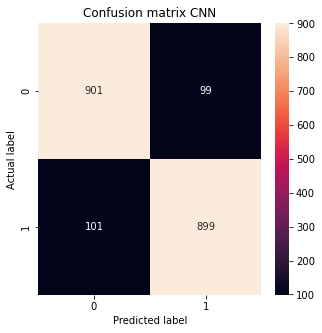

In [17]:
cm = confusion_matrix(val_labels, test_pred_cnn)

#Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix CNN')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Support vector machine (SVM)

In [18]:
#Flatten the images
X_train = train_images_balanced.reshape(train_images_balanced.shape[0], -1)
y_train = train_labels_balanced

#Reduce dimensionality with PCA
pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train)

In [19]:
#Flatten the images
X_test = val_images.reshape(val_images.shape[0], -1)
y_test = val_labels

#Reduce dimensionality with PCA
X_test = pca.transform(X_test)

In [20]:
#Training SVM
clf = svm.SVC(gamma=0.1, C=100)#originally gamma=0.01, 100 c value
clf.fit(X_train, y_train)

SVC(C=100, gamma=0.1)

In [21]:
#Predictions using test/validation set
test_pred_svm = clf.predict(X_test)

In [22]:
#Classification Report
print("Classification Report on Test Images:")
print(classification_report(y_test, test_pred_svm, digits=4))

#AUC on validation set
test_pred_prob_svm = clf.decision_function(X_test) 
test_auc_svm = roc_auc_score(y_test, test_pred_prob_svm)
print("AUC on Test Images:", test_auc_svm)

Classification Report on Test Images:
              precision    recall  f1-score   support

           0     0.9736    0.6650    0.7903      1000
           1     0.7456    0.9820    0.8476      1000

    accuracy                         0.8235      2000
   macro avg     0.8596    0.8235    0.8190      2000
weighted avg     0.8596    0.8235    0.8190      2000

AUC on Test Images: 0.969659


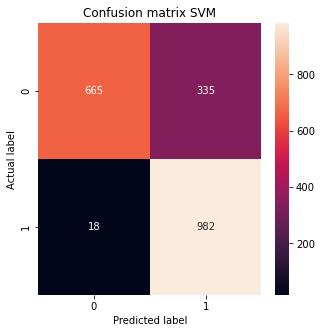

In [23]:
cm = confusion_matrix(val_labels, test_pred_svm)

#Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix SVM')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Random forest

In [24]:
#Flatten the images and reduce dimensionality with PCA for the training set
X_train_rf = train_images_balanced.reshape(train_images_balanced.shape[0], -1)
y_train_rf = train_labels_balanced

X_train_rf = pca.fit_transform(X_train_rf)

# Flatten the images and reduce dimensionality with PCA for the test set
X_test_rf = val_images.reshape(val_images.shape[0], -1)
y_test_rf = val_labels
X_test_rf = pca.transform(X_test_rf)

#Flatten the images (without PCA) for the test set
# X_test_rf = val_images.reshape(val_images.shape[0], -1)
# y_test_rf = val_labels

In [25]:
# Train the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=3)
rf_clf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(n_estimators=3)

In [26]:
# Predictions using the test/validation set
test_pred_rf = rf_clf.predict(X_test_rf)

# Classification Report
print("Classification Report on Test Images:")
print(classification_report(y_test_rf, test_pred_rf, digits=4))

# AUC on validation set
test_pred_prob_rf = rf_clf.predict_proba(X_test_rf)[:, 1]
test_auc_rf = roc_auc_score(y_test_rf, test_pred_prob_rf)
print("AUC on Test Images:", test_auc_rf)

Classification Report on Test Images:
              precision    recall  f1-score   support

           0     0.8419    0.8150    0.8283      1000
           1     0.8207    0.8470    0.8337      1000

    accuracy                         0.8310      2000
   macro avg     0.8313    0.8310    0.8310      2000
weighted avg     0.8313    0.8310    0.8310      2000

AUC on Test Images: 0.8900220000000001


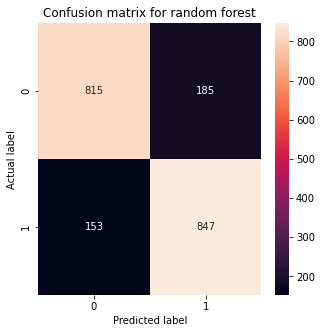

In [27]:
cm = confusion_matrix(y_test_rf, test_pred_rf)

#Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix for random forest')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## ResNet50

In [28]:
def create_resnet_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x) #128 WAS 1024
    x = Dropout(0.2)(x) #original 0.5
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    adam_optimizer = Adam(learning_rate=0.0001) #new line
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [29]:
input_shape = (image_size, image_size, 3)  # Change to 3 channels as ResNet expects RGB images
train_images_rgb = np.repeat(train_images_balanced, 3, axis=-1)  # Repeat grayscale images to make them 3-channel RGB
val_images_rgb = np.repeat(val_images, 3, axis=-1)

resnet_model = create_resnet_model(input_shape)

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

history = resnet_model.fit(train_images_rgb, train_labels_balanced, epochs=20, batch_size=32,
                           validation_data=(val_images_rgb, val_labels),
                           callbacks=[early_stopping])

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 132s 255ms/step - accuracy: 0.5911 - auc: 0.6273 - loss: 0.8440 - val_accuracy: 0.6570 - val_auc: 0.7974 - val_loss: 0.5894
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 124s 249ms/step - accuracy: 0.7024 - auc: 0.7768 - loss: 0.5548 - val_accuracy: 0.7210 - val_auc: 0.8288 - val_loss: 0.5367
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 125s 250ms/step - accuracy: 0.7186 - auc: 0.8007 - loss: 0.5312 - val_accuracy: 0.7465 - val_auc: 0.8427 - val_loss: 0.5123
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 124s 248ms/step - accuracy: 0.7457 - auc: 0.8015 - loss: 0.5393 - val_accuracy: 0.7150 - val_auc: 0.7681 - val_loss: 0.5651
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 130s 259ms/step - accuracy: 0.7295 - auc: 0.7734 - loss: 0.5550 - val_accuracy: 0.7195 - val_auc: 0.8084 - val_loss: 0.5447
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 124s 247ms/step - accuracy: 0.7440 - auc: 0.7953 - loss: 0.5317 - val_accuracy: 0.7380 - val_auc: 0.8334 - val_loss: 0.5313


In [30]:
train_pred_prob_rn = resnet_model.predict(train_images_rgb)
train_pred_rn = (train_pred_prob_rn > 0.5).astype(np.int32)

500/500 ━━━━━━━━━━━━━━━━━━━━ 103s 203ms/step


In [31]:
#training set results
print("Classification Report on Training Images:")
print(classification_report(train_labels_balanced, train_pred_rn, digits=4))

train_auc_rn = roc_auc_score(train_labels_balanced, train_pred_prob_rn)
print("AUC on Training Images:", train_auc)

Classification Report on Training Images:
              precision    recall  f1-score   support

           0     0.7873    0.7692    0.7782      8000
           1     0.7744    0.7921    0.7832      8000

    accuracy                         0.7807     16000
   macro avg     0.7808    0.7807    0.7807     16000
weighted avg     0.7808    0.7807    0.7807     16000

AUC on Training Images: 0.9713925937499999


In [32]:
# Predict probabilities for the test images
test_pred_prob_rn = resnet_model.predict(val_images_rgb)
test_pred_rn = (test_pred_prob_rn > 0.5).astype(np.int32)

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step


In [33]:
#Evaluate the model on the test images
print("Classification Report on Test Images:")
print(classification_report(val_labels, test_pred_rn, digits=4))

test_auc_rn = roc_auc_score(val_labels, test_pred_prob_rn)
print("AUC on Test Images:", test_auc_rn)

Classification Report on Test Images:
              precision    recall  f1-score   support

           0     0.7131    0.8250    0.7650      1000
           1     0.7924    0.6680    0.7249      1000

    accuracy                         0.7465      2000
   macro avg     0.7527    0.7465    0.7449      2000
weighted avg     0.7527    0.7465    0.7449      2000

AUC on Test Images: 0.8428960000000001


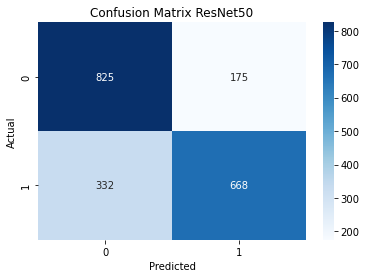

In [34]:
cm = confusion_matrix(val_labels, test_pred_rn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix ResNet50')
plt.show()

# Performance Comparision
The section shows a graph plot comparing how well each model did on the test set

In [35]:
def calculate_all_quantities(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp, tn, fp, fn

#finding quantities for each model
cnn_tp, cnn_tn, cnn_fp, cnn_fn = calculate_all_quantities(val_labels, test_pred_cnn)
svm_tp, svm_tn, svm_fp, svm_fn = calculate_all_quantities(val_labels, test_pred_svm)
rf_tp, rf_tn, rf_fp, rf_fn = calculate_all_quantities(val_labels, test_pred_rf)
resnet_tp, resnet_tn, resnet_fp, resnet_fn = calculate_all_quantities(val_labels, test_pred_rn)

In [36]:
data = {
    'Model': ['CNN', 'SVM', 'Random Forest', 'ResNet50'],
    'True Positives': [cnn_tp, svm_tp, rf_tp, resnet_tp],
    'True Negatives': [cnn_tn, svm_tn, rf_tn, resnet_tn],
    'False Positives': [cnn_fp, svm_fp, rf_fp, resnet_fp],
    'False Negatives': [cnn_fn, svm_fn, rf_fn, resnet_fn]
}

df_quantities = pd.DataFrame(data)

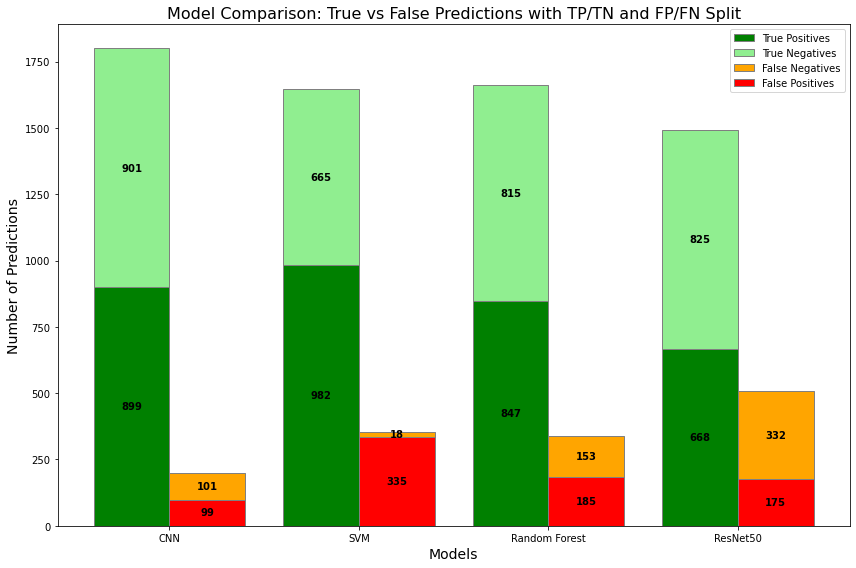

In [37]:
plt.figure(figsize=(12, 8))

#X-axis positions
bar_width = 0.4
r1 = np.arange(len(df_quantities['Model']))

#stacked bar plots for True Positives and True Negatives
plt.bar(r1, df_quantities['True Positives'], color='green', width=bar_width, edgecolor='grey', label='True Positives')
plt.bar(r1, df_quantities['True Negatives'], bottom=df_quantities['True Positives'], color='lightgreen', width=bar_width, edgecolor='grey', label='True Negatives')

#stacked bar plots for False Positives and False Negatives
plt.bar(r1 + bar_width, df_quantities['False Negatives'], bottom=df_quantities['False Positives'], color='orange', width=bar_width, edgecolor='grey', label='False Negatives')
plt.bar(r1 + bar_width, df_quantities['False Positives'], color='red', width=bar_width, edgecolor='grey', label='False Positives')

#Adding labels and title
plt.xlabel('Models', fontsize=14)
plt.ylabel('Number of Predictions', fontsize=14)
plt.title('Model Comparison: True vs False Predictions with TP/TN and FP/FN Split', fontsize=16)
plt.xticks([r + bar_width / 2 for r in range(len(df_quantities['Model']))], df_quantities['Model'])

plt.legend()

#value annotations
for i, model in enumerate(df_quantities['Model']):
    # Annotate True Positives
    plt.text(r1[i], df_quantities['True Positives'][i] / 2, f'{df_quantities["True Positives"][i]}', ha='center', va='center', fontweight='bold')
    # Annotate True Negatives
    plt.text(r1[i], df_quantities['True Positives'][i] + df_quantities['True Negatives'][i] / 2, f'{df_quantities["True Negatives"][i]}', ha='center', va='center', fontweight='bold')
    # Annotate False Positives
    plt.text(r1[i] + bar_width, df_quantities['False Positives'][i] / 2, f'{df_quantities["False Positives"][i]}', ha='center', va='center', fontweight='bold')
    # Annotate False Negatives
    plt.text(r1[i] + bar_width, df_quantities['False Positives'][i] + df_quantities['False Negatives'][i] / 2, f'{df_quantities["False Negatives"][i]}', ha='center', va='center', fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()

## Best model improvements
From the results the best model seems to be CNN based on the classification reports and confusion matrices of the test set. The subsequent code will be attempts to improve the performance of the model further.

In [38]:
def cnn_model_2(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        
        layers.Dense(128, activation='relu'), 
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    adam_optimizer = optimizers.Adam(learning_rate=0.001)#0.0001
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [39]:
#early stopping callback
early_stopping = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

#Training the CNN model
cnn_model_2 = cnn_model_2((image_size, image_size, 1))
history = cnn_model_2.fit(train_images_balanced, train_labels_balanced, epochs=20, batch_size=64,#32
                        validation_data=(val_images, val_labels),
                        callbacks=[early_stopping])

Epoch 1/20


C:\Users\Bakab\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 117s 462ms/step - accuracy: 0.7471 - auc: 0.8233 - loss: 0.9103 - val_accuracy: 0.5000 - val_auc: 0.4626 - val_loss: 3.6719
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 120s 478ms/step - accuracy: 0.8181 - auc: 0.9035 - loss: 0.3931 - val_accuracy: 0.6515 - val_auc: 0.8452 - val_loss: 0.5959
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 120s 480ms/step - accuracy: 0.8424 - auc: 0.9226 - loss: 0.3532 - val_accuracy: 0.6270 - val_auc: 0.8485 - val_loss: 0.7557
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 118s 474ms/step - accuracy: 0.8507 - auc: 0.9328 - loss: 0.3294 - val_accuracy: 0.7385 - val_auc: 0.9312 - val_loss: 0.4611
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 115s 461ms/step - accuracy: 0.8593 - auc: 0.9381 - loss: 0.3172 - val_accuracy: 0.5810 - val_auc: 0.8501 - val_loss: 0.7821
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 111s 442ms/step - accuracy: 0.8702 - auc: 0.9464 - loss: 0.2947 - val_accuracy: 0.5140 - val_auc: 0.5273 - val_loss: 7.0524
Epoch 7/20
250/250 ━━━━━━━━

In [40]:
#Evaluateon the training set
train_pred_prob_cnn2 = cnn_model_2.predict(train_images_balanced)
#Convert probabilities to class labels
train_pred_cnn2 = (train_pred_prob_cnn2 > 0.5).astype(np.int32)

print("Classification Report on Training Images:")
print(classification_report(train_labels_balanced, train_pred_cnn2, digits=4))

#AUC calculation
train_auc = roc_auc_score(train_labels_balanced, train_pred_prob_cnn2)
print("AUC on Training Images:", train_auc)

500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step
Classification Report on Training Images:
              precision    recall  f1-score   support

           0     0.7575    0.9466    0.8416      8000
           1     0.9289    0.6970    0.7964      8000

    accuracy                         0.8218     16000
   macro avg     0.8432    0.8218    0.8190     16000
weighted avg     0.8432    0.8218    0.8190     16000

AUC on Training Images: 0.93495590625


In [41]:
#Predict probabilities for the test images
test_pred_prob_cnn2 = cnn_model_2.predict(val_images)
test_pred_cnn2 = (test_pred_prob_cnn2 > 0.5).astype(np.int32)

#Evaluate the model on the test images
print("Classification Report on Test Images:")
print(classification_report(val_labels, test_pred_cnn2, digits=4))

#AUC calculation
test_auc = roc_auc_score(val_labels, test_pred_prob_cnn2)
print("AUC on Test Images:", test_auc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Classification Report on Test Images:
              precision    recall  f1-score   support

           0     0.6641    0.9650    0.7868      1000
           1     0.9360    0.5120    0.6619      1000

    accuracy                         0.7385      2000
   macro avg     0.8001    0.7385    0.7244      2000
weighted avg     0.8001    0.7385    0.7244      2000

AUC on Test Images: 0.931267


## Parameter tuning

In [27]:
def grid_search_crossVal(X, y, param_grid, cv, epochs, earlyStop):
    results = []

    for params in ParameterGrid(param_grid):
        scores = []
        epochs_list = []

        for train_index, val_index in StratifiedKFold(n_splits=cv).split(X, y):
            X_train_fold, X_val_fold = X[train_index], X[val_index]
            y_train_fold, y_val_fold = y[train_index], y[val_index]
            
            #define the CNN model with current hyperparameters
            model = models.Sequential([
                layers.Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2, 2)),
                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2, 2)),
                layers.Conv2D(128, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2, 2)),
                layers.Flatten(),
                layers.Dense(128, activation='relu'), 
                layers.Dropout(params['dropout']),
                layers.Dense(1, activation='sigmoid')
            ])
            
            adam_optimizer = optimizers.Adam(learning_rate=params['learning_rate'])
            
            model.compile(optimizer=adam_optimizer,
                          loss='binary_crossentropy',
                          metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
            
            early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=earlyStop, restore_best_weights=True)
            history = model.fit(X_train_fold, y_train_fold, batch_size=params['batch_size'], epochs=epochs, 
                                validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=0)
            
            score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            
            scores.append(score)
            epochs_list.append(len(history.history['loss']))
        
        mean_score = np.mean(scores, axis=0)
        mean_epochs = np.mean(epochs_list)
        
        results.append((mean_score, mean_epochs, params))

    results.sort(key=lambda x: x[0][1], reverse=True)

    return results[0]

In [28]:
#parameter grid
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'dropout': [0.2],
    'batch_size': [64, 128]
}

In [29]:
KFOLDS = 5
epochs = 20
earlyStop = 3

In [30]:
best_score, best_epochs, best_params = grid_search_crossVal(train_images_balanced, train_labels_balanced, param_grid, KFOLDS, epochs, earlyStop)
print(f"Best Score: {best_score}, Best Epochs: {best_epochs}, using {best_params}")

C:\Users\Bakab\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Bakab\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Bakab\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_

Best Score: [0.35511203 0.8464375  0.92774736], Best Epochs: 7.2, using {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.0001}


In [40]:
best_loss, best_accuracy, best_auc = best_score
print(f"Best Accuracy: {best_accuracy:.4f}, Best AUC: {best_auc:.4f}, using {best_params}")
print(f"Number of Epochs: {best_epochs:.1f}")

Best Accuracy: 0.8464, Best AUC: 0.9277, using {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.0001}
Number of Epochs: 7.2


# Conclusion and evaluating on second dataset

In [42]:
dataset2_test = 'data/test_secondset'

In [43]:
test_df_second = create_df(dataset2_test)
print("Test set summary:")
print(test_df_second['label'].value_counts())

Test set summary:
benign       360
malignant    300
Name: label, dtype: int64


In [44]:
#Preprocess second set
test_images_second, test_labels_second = df_preprocessing(test_df_second, image_size)

In [45]:
# Predict probabilities for the second test images
test_pred_prob_cnn_second = cnn_model.predict(test_images_second)
test_pred_cnn_second = (test_pred_prob_cnn_second > 0.5).astype(np.int32)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [47]:
#Evaluate the model on the test images
print("Classification Report on Second Test Images:")
print(classification_report(test_labels_second, test_pred_cnn_second, digits=4))

#AUC calculation
test_auc = roc_auc_score(test_labels_second, test_pred_prob_cnn_second)
print("AUC on Test Images:", test_auc)

Classification Report on Second Test Images:
              precision    recall  f1-score   support

           0     0.9073    0.7889    0.8440       360
           1     0.7810    0.9033    0.8377       300

    accuracy                         0.8409       660
   macro avg     0.8442    0.8461    0.8408       660
weighted avg     0.8499    0.8409    0.8411       660

AUC on Test Images: 0.9441759259259259


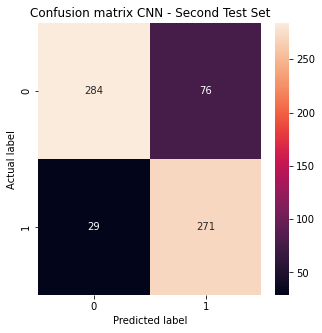

In [48]:
cm_second = confusion_matrix(test_labels_second, test_pred_cnn_second)

# Plot the confusion matrix for the second test images
plt.figure(figsize=(5, 5))
sns.heatmap(cm_second, annot=True, fmt="d")
plt.title('Confusion matrix CNN - Second Test Set')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()